# Tutorial: Nonlinear relativistic case, plasma refinement

### First import all classes necessary for simulation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar

# Main classes for simulation, plasma, driver field and species
from qsa_pwfa.simulation import Simulation
from qsa_pwfa.species import NeutralUniformPlasma
from qsa_pwfa.external_fields import GaussianBunchField

# Diagnostics
from qsa_pwfa.diagnostics import FieldDiagnostics
from qsa_pwfa.diagnostics import SpeciesDiagnostics

### Code space and time units are normalized to plasma $k_p^{-1}$, $\omega_p^{-1}$. For this example let us consider input in SI units corresponding to plasma density $2\cdot 10^{18}$ cm$^{-3}$.

In [2]:
n_plasma = 2e18 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

### Let us define a driver beam

In [3]:
Q_drv = 200e-12 # Beam charge in [C]

sigma_R_drv = 2e-6 / k_p_inv   # beam radius of []
sigma_Xi_drv = 2e-6 / k_p_inv
ksi0_drv = 5 * sigma_Xi_drv
n_drv = Q_drv / e / (2*np.pi)**1.5 / (k_p_inv*sigma_R_drv)**2 / (k_p_inv*sigma_Xi_drv) / n_plasma 

### and uniform plasma with a longitudinal and transverse sizes of 3 plasma waves

In [4]:
# plasma
L_xi = 3 * (2*np.pi)
L_r =  1 * (2*np.pi)

# grid
N_xi = 512 * 2
N_r = 512

d_xi = L_xi / N_xi
dr = L_r / N_r

### Now lets setup and run the simulation

In [5]:
driver_bunch = GaussianBunchField(n_drv, sigma_R_drv, sigma_Xi_drv)
plasma = NeutralUniformPlasma(L_r=L_r, N_r=N_r)

sim = Simulation(L_xi=L_xi, N_xi=N_xi)
sim.add_specie( plasma )
sim.add_external_field( driver_bunch )

sim.diagnostics = [ 
    FieldDiagnostics( sim, L_r=L_r, N_r=N_r,
                      fields=['Density', ], 
                      xi_step=2, 
                      ),
    SpeciesDiagnostics( sim, sim.species[-1], 
                      fields=['v_z',],
                      xi_step=2 )
]

sim.run_step()

  0%|          | 0/1024 [00:00<?, ?it/s]

reached max PC iterations at i_xi=432 (xi=7.9521564043991635), with an error 0.00967643
Specie 0 had 0.333733% violated QSA


### Now we plot the electron density

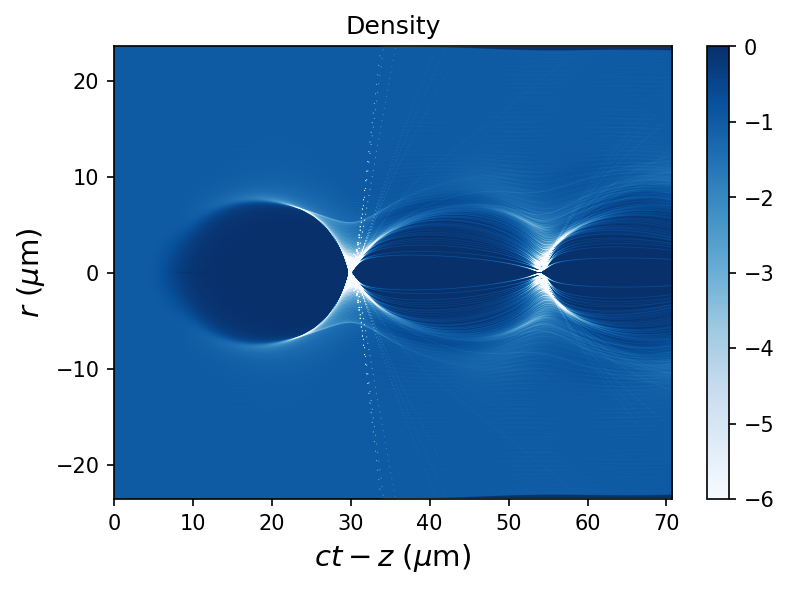

In [6]:
diag = sim.diagnostics[0]
ext = np.array([ diag.xi.min(),
                 diag.xi.max(),
                -diag.grid.rmax,
                 diag.grid.rmax ]) * k_p_inv * 1e6

for fld in diag.fields: 
    for i_t, outout in enumerate(diag.outputs):
        val = outout[fld]
        val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))

        plt.figure(dpi=150)

        vmin = -6
        plt.imshow(val_ext.T,
                origin='lower',
                aspect='auto',
                cmap=plt.cm.Blues,
                vmax=0,
                vmin=vmin,
                extent=ext
                )

        plt.colorbar()
        plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
        plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)

        plt.title(f"{fld}")

### These "white" dense particles behind the first bubble approach the limit of QSA applicability (same conditions as in HiPACE: $\gamma_e/(1+\Psi)\le 35$)
### Let us check evolution of $v_z$ and find from which $r_0$ they are coming from:

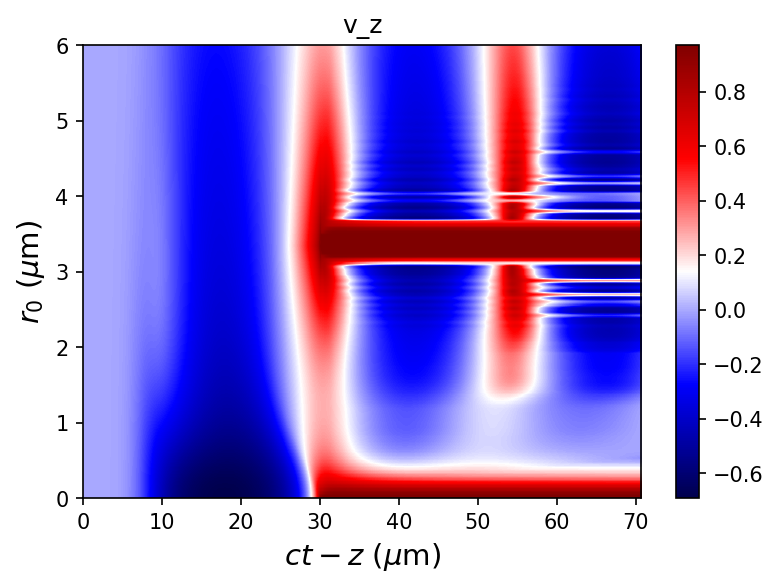

In [7]:
diag = sim.diagnostics[1]
ext = np.array([ diag.xi.min(),
                 diag.xi.max(),
                 0,
                 diag.grid.rmax ]) * k_p_inv * 1e6

for fld in diag.fields: 
    for i_t, outout in enumerate(diag.outputs[::3]):
        val = outout[fld]
        plt.figure(dpi=150)
        
        plt.imshow(val.T,
                origin='lower', aspect='auto',
                cmap=plt.cm.seismic, extent=ext)

        plt.colorbar()
        plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
        plt.ylabel(r'$r_0$ ($\mu$m)', fontsize=14)

        plt.title(f"{fld}")
        plt.ylim(0, 6)

### Guilty electrons come from $r_0\in [3, 4]$.
### Let's reduce individual weigths of the particles by using higher resolution in this region:

In [8]:
r1 = 3e-6 / k_p_inv
r2 = 4e-6 / k_p_inv
N_r_hires = N_r

# copying grid from previous simulation and adding a resolved region
r_grid = plasma.r0.copy() 
r_grid_below = r_grid[r_grid<=r1]
r_grid_above = r_grid[r_grid>=r2]
r_grid_middle = np.r_[r_grid_below[-1] : r_grid_above[0] : N_r_hires*1j]

r_grid_user = np.r_[
    r_grid_below[:-1],
    r_grid_middle,
    r_grid_above[1:] 
]

plasma = NeutralUniformPlasma(r_grid_user=r_grid_user)

sim = Simulation(L_xi=L_xi, N_xi=N_xi)
sim.add_specie( plasma )
sim.add_external_field( driver_bunch )

sim.diagnostics = [ 
    FieldDiagnostics( sim, L_r=L_r, N_r=N_r,
                      fields=['Density', ], 
                      xi_step=2, 
                      ),
    SpeciesDiagnostics( sim, sim.species[-1], 
                      fields=['v_z',],
                      xi_step=2 )
]

sim.run_step()

  0%|          | 0/1024 [00:00<?, ?it/s]

reached max PC iterations at i_xi=0 (xi=0.0), with an error 0.0140128
reached max PC iterations at i_xi=433 (xi=7.970564173853791), with an error 0.0129595
Specie 0 had 0.32069% violated QSA


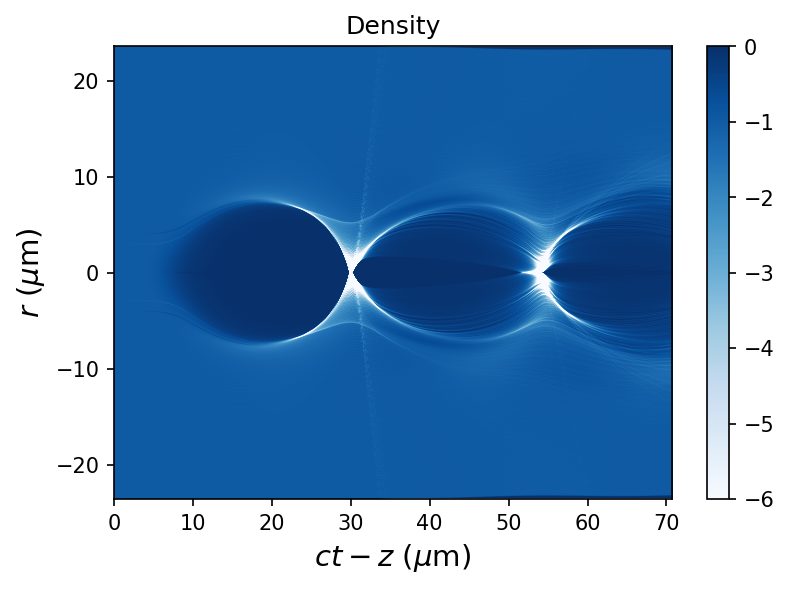

In [9]:
diag = sim.diagnostics[0]
ext = np.array([ diag.xi.min(),
                 diag.xi.max(),
                -diag.grid.rmax,
                 diag.grid.rmax ]) * k_p_inv * 1e6

for fld in diag.fields: 
    for i_t, outout in enumerate(diag.outputs):
        val = outout[fld]
        val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))

        plt.figure(dpi=150)

        vmin = -6
        plt.imshow(val_ext.T,
                origin='lower',
                aspect='auto',
                cmap=plt.cm.Blues,
                vmax=0,
                vmin=vmin,
                extent=ext
                )

        plt.colorbar()
        plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
        plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)

        plt.title(f"{fld}")